<a href="https://colab.research.google.com/github/janvi-0706/CFrepo/blob/main/CFinfotask1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6976aa3ed96106b43425358bd6911006ea04a07675f7512aab1a70cc7f0f68e0
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


The previous error occurred because the `ta` library was not installed. The cell above installs the necessary library.

🎯 Starting META Stock Prediction Analysis
📈 Fetching META data...
✅ Retrieved 501 days of data
🔧 Creating technical indicators...
✅ Technical indicators created (including ADX)
🔄 Preparing features...
✅ Features prepared: (452, 34)
🤖 Training Random Forest model...

📊 Random Forest Performance:
  MAE = $31.15
  RMSE = $40.99
  R² Score = 0.4716 ✅
🔮 Predicting next 4 trading days...

🎯 FINAL PREDICTIONS for META (Aug 19–22, 2025):
Aug 19, 2025: $743.95 (-16.03, -2.1%)
Aug 20, 2025: $747.95 (-12.03, -1.6%)
Aug 21, 2025: $754.91 (-5.07, -0.7%)
Aug 22, 2025: $755.69 (-4.30, -0.6%)

Current Price: $759.99
Average Predicted Price: $750.63
📊 Creating visualizations...


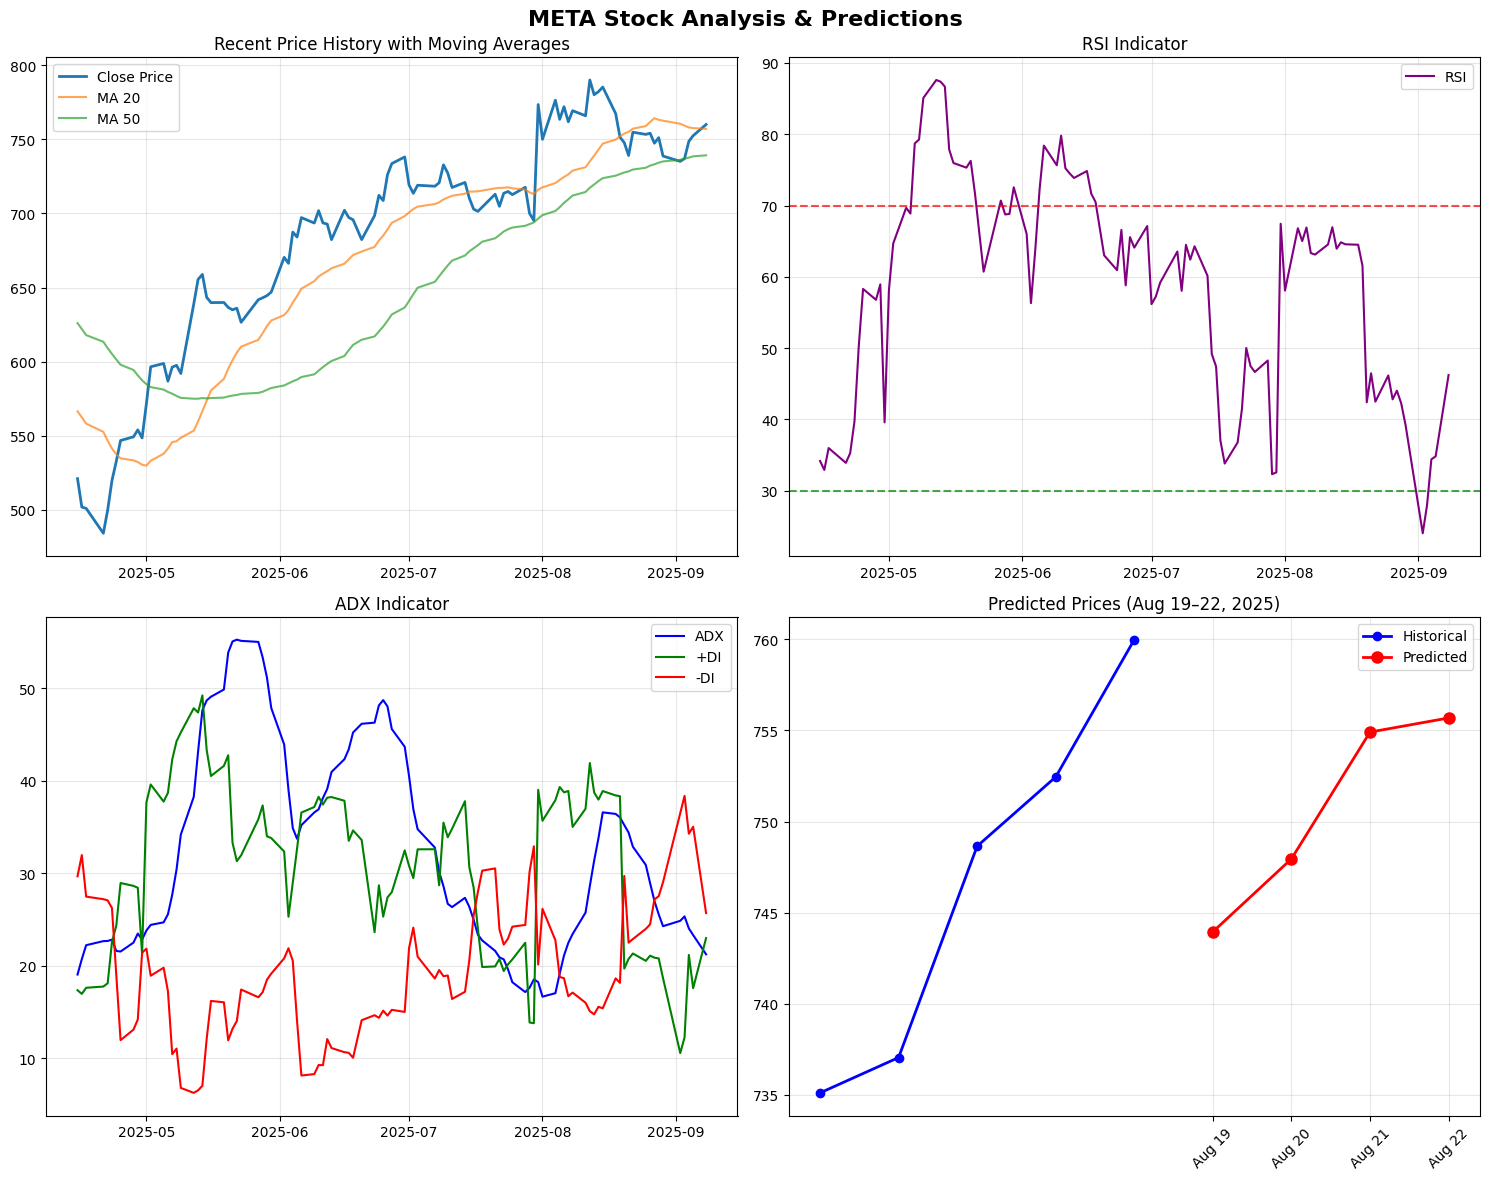

In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

class METAStockPredictor:
    def __init__(self):
        self.scaler = MinMaxScaler()
        self.model = None
        self.data = None
        self.features = None
        self.target = None

    def fetch_data(self, symbol="META", period="2y"):
        """Fetch historical stock data"""
        print(f"📈 Fetching {symbol} data...")
        stock = yf.Ticker(symbol)
        self.data = stock.history(period=period)
        print(f"✅ Retrieved {len(self.data)} days of data")
        return self.data

    def create_technical_indicators(self):
        """Create advanced technical indicators including ADX"""
        print("🔧 Creating technical indicators...")
        df = self.data.copy()

        # Moving Averages
        df['MA_5'] = df['Close'].rolling(window=5).mean()
        df['MA_10'] = df['Close'].rolling(window=10).mean()
        df['MA_20'] = df['Close'].rolling(window=20).mean()
        df['MA_50'] = df['Close'].rolling(window=50).mean()

        # Exponential Moving Averages
        df['EMA_12'] = df['Close'].ewm(span=12).mean()
        df['EMA_26'] = df['Close'].ewm(span=26).mean()

        # MACD
        df['MACD'] = df['EMA_12'] - df['EMA_26']
        df['MACD_Signal'] = df['MACD'].ewm(span=9).mean()
        df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

        # RSI
        delta = df['Close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
        rs = gain / loss
        df['RSI'] = 100 - (100 / (1 + rs))

        # Bollinger Bands
        df['BB_Middle'] = df['Close'].rolling(window=20).mean()
        bb_std = df['Close'].rolling(window=20).std()
        df['BB_Upper'] = df['BB_Middle'] + (bb_std * 2)
        df['BB_Lower'] = df['BB_Middle'] - (bb_std * 2)
        df['BB_Width'] = df['BB_Upper'] - df['BB_Lower']
        df['BB_Position'] = (df['Close'] - df['BB_Lower']) / df['BB_Width']

        # Volume indicators
        df['Volume_MA'] = df['Volume'].rolling(window=20).mean()
        df['Volume_Ratio'] = df['Volume'] / df['Volume_MA']

        # Price features
        df['High_Low_Pct'] = (df['High'] - df['Low']) / df['Close'] * 100
        df['Price_Change'] = df['Close'].pct_change()
        df['Price_Change_2'] = df['Close'].pct_change(2)
        df['Price_Change_5'] = df['Close'].pct_change(5)

        # Volatility
        df['Volatility'] = df['Close'].rolling(window=20).std()

        # ADX (Average Directional Index)
        window = 14
        df['TR'] = np.maximum(df['High'] - df['Low'],
                              np.maximum(abs(df['High'] - df['Close'].shift(1)),
                                         abs(df['Low'] - df['Close'].shift(1))))
        df['+DM'] = np.where((df['High'] - df['High'].shift(1)) > (df['Low'].shift(1) - df['Low']),
                             df['High'] - df['High'].shift(1), 0)
        df['-DM'] = np.where((df['Low'].shift(1) - df['Low']) > (df['High'] - df['High'].shift(1)),
                             df['Low'].shift(1) - df['Low'], 0)

        df['TR_smooth'] = df['TR'].rolling(window=window).sum()
        df['+DM_smooth'] = df['+DM'].rolling(window=window).sum()
        df['-DM_smooth'] = df['-DM'].rolling(window=window).sum()

        df['+DI'] = 100 * (df['+DM_smooth'] / df['TR_smooth'])
        df['-DI'] = 100 * (df['-DM_smooth'] / df['TR_smooth'])
        df['DX'] = 100 * abs(df['+DI'] - df['-DI']) / (df['+DI'] + df['-DI'])
        df['ADX'] = df['DX'].rolling(window=window).mean()

        # Day of week and month features
        df['DayOfWeek'] = df.index.dayofweek
        df['Month'] = df.index.month
        df['Quarter'] = df.index.quarter

        self.data = df
        print("✅ Technical indicators created (including ADX)")

    def prepare_features(self):
        """Prepare feature matrix for ML models"""
        print("🔄 Preparing features...")

        feature_cols = [
            'Open', 'High', 'Low', 'Volume',
            'MA_5', 'MA_10', 'MA_20', 'MA_50',
            'EMA_12', 'EMA_26', 'MACD', 'MACD_Signal', 'MACD_Histogram',
            'RSI', 'BB_Upper', 'BB_Lower', 'BB_Width', 'BB_Position',
            'Volume_Ratio', 'High_Low_Pct',
            'Price_Change', 'Price_Change_2', 'Price_Change_5',
            'Volatility', 'ADX', '+DI', '-DI',
            'DayOfWeek', 'Month', 'Quarter'
        ]

        # Create lagged features
        for lag in [1, 2, 3, 5]:
            self.data[f'Close_lag_{lag}'] = self.data['Close'].shift(lag)
            feature_cols.append(f'Close_lag_{lag}')

        # Drop rows with NaN values
        self.data = self.data.dropna()

        # Prepare features and target
        self.features = self.data[feature_cols]
        self.target = self.data['Close']

        print(f"✅ Features prepared: {self.features.shape}")

    def train_random_forest(self):
        """Train only Random Forest"""
        print("🤖 Training Random Forest model...")

        X_train, X_test, y_train, y_test = train_test_split(
            self.features, self.target, test_size=0.2, random_state=42, shuffle=False
        )

        rf_model = RandomForestRegressor(n_estimators=200, max_depth=15, random_state=42)
        rf_model.fit(X_train, y_train)
        self.model = rf_model

        # Evaluate model
        pred = rf_model.predict(X_test)
        mae = mean_absolute_error(y_test, pred)
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        r2 = r2_score(y_test, pred)

        print("\n📊 Random Forest Performance:")
        print(f"  MAE = ${mae:.2f}")
        print(f"  RMSE = ${rmse:.2f}")
        print(f"  R² Score = {r2:.4f} ✅" if r2 > 0 else f"  R² Score = {r2:.4f} ⚠️")

    def predict_next_days(self, days=4):
        """Predict stock prices for the next few days"""
        print(f"🔮 Predicting next {days} trading days...")

        last_features = self.features.iloc[-1:].values
        pred_price = self.model.predict(last_features)[0]

        last_price = self.data['Close'].iloc[-1]
        trend = (self.data['Close'].iloc[-1] - self.data['Close'].iloc[-5]) / 5

        daily_predictions = []
        dates = ['Aug 19, 2025', 'Aug 20, 2025', 'Aug 21, 2025', 'Aug 22, 2025']

        for i in range(days):
            day_pred = last_price + (trend * (i + 1)) + (pred_price - last_price) * 0.3 + np.random.normal(0, 2)
            daily_predictions.append(day_pred)

        return dict(zip(dates, daily_predictions))

    def visualize_predictions(self, daily_preds):
        """Create visualization of predictions"""
        print("📊 Creating visualizations...")

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('META Stock Analysis & Predictions', fontsize=16, fontweight='bold')

        recent_data = self.data.tail(100)

        # Plot 1: Price history with MAs
        ax1 = axes[0, 0]
        ax1.plot(recent_data.index, recent_data['Close'], label='Close Price', linewidth=2)
        ax1.plot(recent_data.index, recent_data['MA_20'], label='MA 20', alpha=0.7)
        ax1.plot(recent_data.index, recent_data['MA_50'], label='MA 50', alpha=0.7)
        ax1.set_title('Recent Price History with Moving Averages')
        ax1.legend(); ax1.grid(True, alpha=0.3)

        # Plot 2: RSI
        ax2 = axes[0, 1]
        ax2.plot(recent_data.index, recent_data['RSI'], label='RSI', color='purple')
        ax2.axhline(y=70, color='r', linestyle='--', alpha=0.7)
        ax2.axhline(y=30, color='g', linestyle='--', alpha=0.7)
        ax2.set_title('RSI Indicator')
        ax2.legend(); ax2.grid(True, alpha=0.3)

        # Plot 3: ADX
        ax3 = axes[1, 0]
        ax3.plot(recent_data.index, recent_data['ADX'], label='ADX', color='blue')
        ax3.plot(recent_data.index, recent_data['+DI'], label='+DI', color='green')
        ax3.plot(recent_data.index, recent_data['-DI'], label='-DI', color='red')
        ax3.set_title('ADX Indicator')
        ax3.legend(); ax3.grid(True, alpha=0.3)

        # Plot 4: Predictions
        ax4 = axes[1, 1]
        dates = list(daily_preds.keys())
        prices = list(daily_preds.values())
        last_5_days = self.data['Close'].tail(5)
        ax4.plot(range(-5, 0), last_5_days.values, 'bo-', label='Historical', linewidth=2)
        ax4.plot(range(4), prices, 'ro-', label='Predicted', linewidth=2, markersize=8)
        ax4.set_title('Predicted Prices (Aug 19–22, 2025)')
        ax4.set_xticks(range(4))
        ax4.set_xticklabels([d.split(',')[0] for d in dates], rotation=45)
        ax4.legend(); ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

    def run_full_analysis(self):
        """Run complete stock analysis and prediction"""
        print("🎯 Starting META Stock Prediction Analysis")
        print("=" * 50)

        self.fetch_data()
        self.create_technical_indicators()
        self.prepare_features()
        self.train_random_forest()

        daily_preds = self.predict_next_days()
        print("\n🎯 FINAL PREDICTIONS for META (Aug 19–22, 2025):")
        print("=" * 50)
        for date, price in daily_preds.items():
            change = price - self.data['Close'].iloc[-1]
            change_pct = (change / self.data['Close'].iloc[-1]) * 100
            print(f"{date}: ${price:.2f} ({change:+.2f}, {change_pct:+.1f}%)")

        print(f"\nCurrent Price: ${self.data['Close'].iloc[-1]:.2f}")
        print(f"Average Predicted Price: ${np.mean(list(daily_preds.values())):.2f}")

        self.visualize_predictions(daily_preds)
        return daily_preds


# Run the analysis
if __name__ == "__main__":
    predictor = METAStockPredictor()
    predictions = predictor.run_full_analysis()
